In [1]:
import warnings
warnings.filterwarnings("ignore")

from unsloth import FastLanguageModel
import torch

from multiprocessing import cpu_count
num_proc = cpu_count()

import yaml

from data_processor import SplittedJsonIoDataset
from customs import customize_tokenizer

from unsloth import UnslothTrainer, UnslothTrainingArguments

from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from transformers import TrainingArguments, DataCollatorForSeq2Seq, DataCollatorForLanguageModeling
from unsloth import is_bfloat16_supported

from unsloth.chat_templates import train_on_responses_only

from unsloth import unsloth_train

from utils import save_log_history

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
# Clear GPU cache
torch.cuda.empty_cache()

In [3]:
with open("config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

model, tokenizer = FastLanguageModel.from_pretrained(
    **config["model_loading_args"]
)

model, tokenizer = customize_tokenizer(model, tokenizer, config)

==((====))==  Unsloth 2025.6.8: Fast Llama patching. Transformers: 4.53.0.
   \\   /|    NVIDIA H100 PCIe. Num GPUs = 1. Max memory: 79.19 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 9.0. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth: unsloth/llama-3-8b-instruct-bnb-4bit can only handle sequence lengths of at most 8192.
But with kaiokendev's RoPE scaling of 8.0, it can be magically be extended to 65536!


In [4]:
# Create dataset for training
dataset = SplittedJsonIoDataset(tokenizer, config).create()

In [5]:
# Add LoRA weights
model = FastLanguageModel.get_peft_model(
    model=model,
    **config["lora_parameters"]
)

Unsloth: Offloading output_embeddings to disk to save VRAM


Unsloth 2025.6.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


Unsloth: Training lm_head in mixed precision to save VRAM


In [6]:
# Select data collator
if config["fine_tuning_args"]["training_type"]=="text_completion":
    _train_on_responses_only_bool = True
    data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer)
elif config["fine_tuning_args"]["training_type"]=="continued_pre_training":
    _train_on_responses_only_bool = False
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
else:
    raise Exception("Wrong Training Type. Check config.yaml")

In [7]:
# Initiate trainer
trainer = UnslothTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset["train"],
    eval_dataset = dataset["eval"],
    data_collator = data_collator,
    dataset_text_field = "text",
    max_seq_length = config["model_loading_args"]["max_seq_length"], # Used only when packing=True for creating a ConstantLengthDataset.
    packing = config["sft_trainer_arguments"]["apply_packing"],
    dataset_num_proc = 1,
    args = UnslothTrainingArguments(
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        **config["training_arguments"]
    )
)

Unsloth: Tokenizing ["text"]: 100%|██████████| 207/207 [00:01<00:00, 142.97 examples/s]


In [8]:
# Wrap trainer for apply training using only the assistant part
if _train_on_responses_only_bool:
    trainer = train_on_responses_only(
        trainer,
        instruction_part = config["instruction_part"],
        response_part = config["response_part"]
    )

Map (num_proc=30): 100%|██████████| 207/207 [00:10<00:00, 20.44 examples/s]


In [9]:
# Start training
trainer_stats = unsloth_train(trainer)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,564 | Num Epochs = 2 | Total steps = 196
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 16 x 1) = 16
 "-____-"     Trainable parameters = 546,308,096/8,000,000,000 (6.83% trained)


Unsloth: Setting lr = 5.00e-06 instead of 5.00e-05 for lm_head.
Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
1,6.315200,5.470305
2,6.093200,5.469119
3,7.770400,5.463514
4,7.094700,5.452961
5,6.782600,5.433033
6,8.236600,5.392967
7,7.975800,5.330557
8,7.196100,5.229848
9,6.844600,5.076637
10,7.240900,4.870210


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


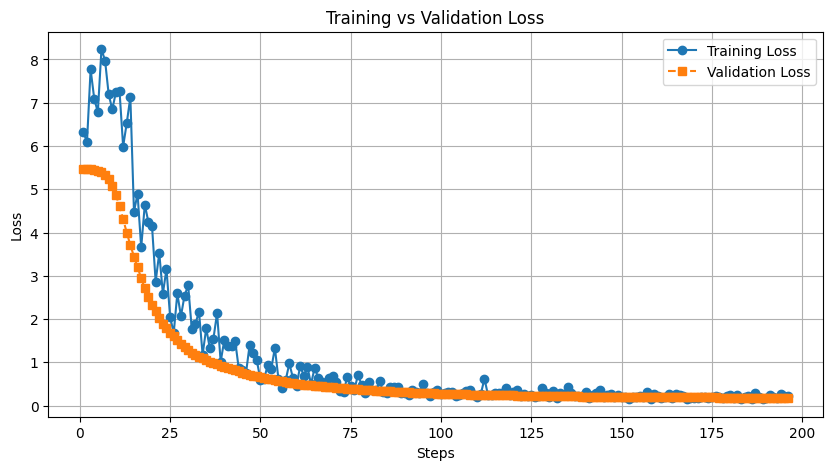

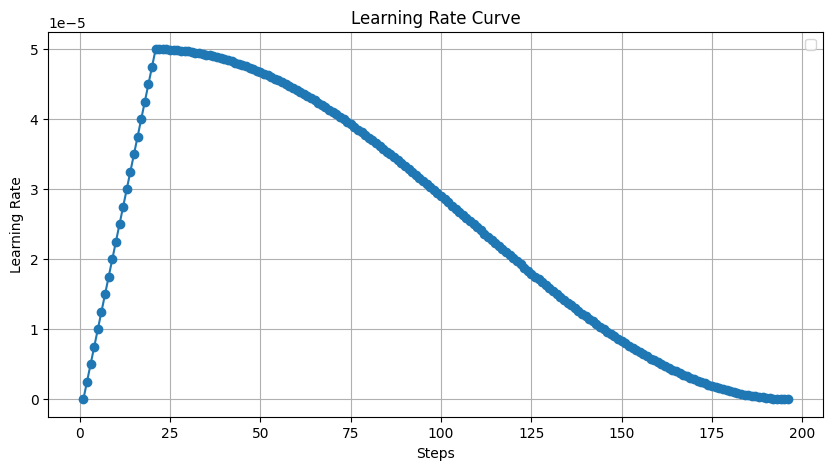

In [10]:
save_log_history(trainer)

In [ ]:
# !sudo mkdir /mnt/data/training-outputs
# !sudo mkdir /mnt/data/training-outputs/first-run
# !sudo cp -r outputs /mnt/data/training-outputs/first-run
# !sudo cp -r log_history /mnt/data/training-outputs/first-run
# !ls /mnt/data/training-outputs/first-run

In [106]:
from transformers import TextStreamer

FastLanguageModel.for_inference(model)
text_streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

def format_input_prompt(system_message, user_input):
    formatted_input = [
        {"role": "assistant", "content": system_message},
        {"role": "user", "content": user_input}
    ]
    return formatted_input

def format_validation_example_for_inference(example):
    return example.split("<|start_header_id|>user<|end_header_id|>")[1].split("<|eot_id|><|start_header_id|>assistant<|end_header_id|>")[0]

def inference(model, system_message, user_input, max_new_tokens=None, **kwargs):
    input_ids = tokenizer.apply_chat_template(
        format_input_prompt(system_message, user_input),
        add_generation_prompt=True,
        return_tensors = "pt").to("cuda")
    if not max_new_tokens:
        max_new_tokens = model.config.max_position_embeddings - input_ids.shape[-1]
    model.generate(input_ids, streamer = text_streamer, max_new_tokens=max_new_tokens, **kwargs)

In [101]:
system_message = ""
user_input = "Hello! How are you?"
inference(model, system_message, user_input, max_new_tokens=100)

I'm just an AI, I don't have feelings or emotions, but I'm functioning properly and ready to assist you with any questions or tasks you may have. How about you? Are you doing well?


In [107]:
system_message = config["system_message"]
user_input = format_validation_example_for_inference(dataset["eval"]["text"][134])
inference(model,
          system_message, 
          user_input, 
          max_new_tokens=None,
          temperature=0.7,
          top_p=0.6,
          repetition_penalty=1.1,
          no_repeat_ngram_size=3,
          do_sample=True)

Generate STIX1.0 bundle: {'id': '', 'type': 'bundle', 'objects': [{'id': report--Large-Sale-StrelaTealer-Campaign-in-Early-2024', 'type": report', 'name': 'Large-Sales-Strelasteeler-Campaign-on-Earlies-2023', 'description': 'An emerging threat actor targets organizations across Europe and U.A. with a large-scale attack campaign that involves sending email attachments with payloads designed to evade security vendors.'}, {'id':'indicator--strelastealed', 'category': 'intrusion-set', 'pattern': "[file:hashes = {'SHA-256': '0d23a3f3e6916be3f6d75402'}]'}, {'id':''}, {'type': '', "name": strelstealer', relationship_type': 'targets', source_ref': 'indicator--malware-family', 'target_ref': ['indicator--mallspam']}, {'value': '[{"indicator--mallsapam", "type": "intrusion-pattern", "pattern": "[file.hashes = {{SHA-224': 'e6991e690442'}]}'], {'id:''}, {'category': "attack-pattern", 'pattern_types': ['intrusion-trend'], 'name_values': ['strelastehello', 'is_family': strestela-stealer', "uses_c2_se